In [2]:
# -*- coding: utf-8 -*-
"""
Created on Fri Oct 27 20:50:31 2023

@author: RJha
"""
import xarray as xr
import numpy as np
from pyhomogeneity import pettitt_test
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import seaborn as sns
from pyhomogeneity import pettitt_test

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import TwoSlopeNorm

In [3]:
ds =  xr.open_dataset("/mnt/nas153/Roshan/PhD_Project_3/WV_Daily.nc")

vort = ds.vo.sel(level=200)

##################################################Difference in Regime - Vorticity  #####################################################################
lats = vort.latitude.values
lons = vort.longitude.values

vort_R1 = vort.sel(time=slice("1973","1997"))
vort_R2 = vort.sel(time=slice("1998","2022"))

diff_R2_R1 = vort_R2.mean(dim=['time']) - vort_R1.mean(dim=['time'])

###############t-test with unequal variance#########################################################

result = np.zeros([len(lats),len(lons)])
sig = np.zeros([len(lats),len(lons)])
sig[:] = np.nan


for i,lat in enumerate(lats):
    for j,lon in enumerate(lons):
        if (np.isnan(vort_R1[0,i,j])):
            result[i,j] = np.nan
        else:
            t, p = stats.ttest_ind(vort_R1[:,i,j], vort_R2[:,i,j],equal_var=False) 
            result[i,j]=t
            if p<0.05:
                sig[i,j]=1


vort_Regime = xr.Dataset({"1973-1997": (('lat','lon'), vort_R1.mean(dim=['time']).values),
                           "1998-2022": (('lat','lon'), vort_R2.mean(dim=['time']).values),
                           "dif": (('lat','lon'), diff_R2_R1.values),
                           "sig": (('lat','lon'), sig)},
                          coords={'lat': lats, 'lon': lons})


#####

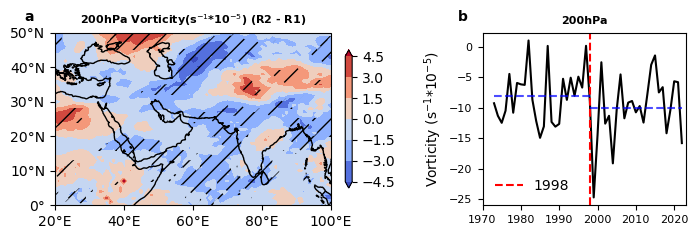

In [5]:

# Set up the figure with cartopy projection
fig = plt.figure(figsize=(8,2.5))

ax3 = plt.subplot2grid(shape=(1,3), loc=(0, 0), colspan=2, fig=fig, projection=ccrs.PlateCarree())

pvalue_mask = np.where(vort_Regime.sig == 1, 1, np.nan)
# Plot the trend data using contourf
diff_plot = ax3.contourf(vort_Regime.lon, vort_Regime.lat, vort_Regime.dif*10e5, transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both')

# Add a colorbar
cbar = plt.colorbar(diff_plot, orientation='vertical', pad=0.03, shrink=0.8)
#cbar.set_label('Vorticity (s$^{-1}$ * 10$^{-6}$)',labelpad=1)

# Add hatching to the sections where p-value is 1
hatch_plot = ax3.contourf(vort_Regime.lon, vort_Regime.lat, pvalue_mask, hatches=['//'], alpha=0, transform=ccrs.PlateCarree())

rect_coords = [70, 20, 80, 30]  # [lon_min, lat_min, lon_max, lat_max]
 # Add a rectangular box to the plot with specific lat,lon coordinates
lon_min, lat_min, lon_max, lat_max = rect_coords
width = lon_max - lon_min
height = lat_max - lat_min
rect = Rectangle((lon_min, lat_min), width, height, linewidth=2,linestyle='--', edgecolor='cyan', facecolor='none', transform=ccrs.PlateCarree())
#ax3.add_patch(rect)

# Add coastlines and gridlines
ax3.coastlines()

# Longitude labels
ax3.set_xticks(np.arange(20,105,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax3.xaxis.set_major_formatter(lon_formatter)

# Latitude labels
ax3.set_yticks(np.arange(0,60,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax3.yaxis.set_major_formatter(lat_formatter)

# Crop the plot
ax3.set_extent([20, 100, 0, 50],crs=ccrs.PlateCarree())
 
# Title
ax3.set_title('200hPa Vorticity(s$^{-1}$*10$^{-5}$) (R2 - R1)',fontdict={'fontsize': 8, 'fontweight': 'bold'})   
ax3.text(-0.075, 1.05, 'a',verticalalignment='bottom', horizontalalignment='right',transform=ax3.transAxes,color='k', weight='bold')


####
ax2 = plt.subplot2grid(shape=(1, 3), loc=(0, 2), colspan=1, fig=fig)

vort_MAM = vort.groupby('time.year').mean(dim='time')

u = vort_MAM.sel(latitude=slice(30,20),longitude=slice(70,80)).mean(dim=['latitude','longitude'])*10e5
res = pettitt_test(u)

# Pettitt test result
change_point = res.cp
cp_year = u.year[change_point-1].values
mu1 = round(res.avg.mu1,2)
mu2 = round(res.avg.mu2,2)  
pval = res.p
# Data
years = u.year

# Plot data and trend lines
ax2.plot(years, u, color='black',linestyle='solid')

if pval < 0.05:
    ax2.axvline(x=years[change_point-1], color='r', linestyle='--', label=f'{cp_year}*')
else:
    ax2.axvline(x=years[change_point-1], color='r', linestyle='--', label=f'{cp_year}')

ax2.plot([1973, years[change_point-1]], [mu1, mu1], color='b', linestyle='--',alpha=0.7) #, label=f'Regime 1 Mean: {mu1_era}')
ax2.plot([years[change_point-1],2022], [mu2, mu2], color='b', linestyle='--', alpha=0.7) #,label=f'Regime 2 Mean: {mu2_era}')
ax2.set_xlim(1970,2023)
#ax2.set_ylim(18,36)

# Labels and legend
ax2.set_ylabel('Vorticity (s$^{-1}$*10$^{-5}$)', fontsize=10)
ax2.legend(loc='lower left',frameon=False, ncol=1)
ax2.tick_params(axis='both', which='major', labelsize=8)
ax2.set_title('200hPa',fontdict={'fontsize': 8, 'fontweight': 'bold'})   
ax2.text(-0.075, 1.05, 'b',verticalalignment='bottom', horizontalalignment='right',transform=ax2.transAxes,color='k', weight='bold')

plt.tight_layout()
plt.savefig('SFigure_2.png', dpi=600,bbox_inches='tight')
plt.savefig('SFigure_2.pdf', dpi=600,bbox_inches='tight')